In [1]:
!pip install transformers

# Проект: Поиск по изображениям

Разработать демо-версию системы поиска изображений по запросу. Модель должна преобразовывать изображение и текст в векторы и оценивать их соответствие (0-1).

**Данные:**

`train_dataset.csv` содержит:

- имя файла изображения
- идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>.`
- текст описания
*(максимум 5 описаний на изображение)*

`train_images/` - директория с обучающими изображениями

`CrowdAnnotations.tsv` (краудсорсинг):

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

`ExpertAnnotations.tsv` (экспертные оценки):

1. Имя файла изображения.
2. Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

*Шкала оценок экспертов:*

1 - изображение и запрос совершенно не соответствуют друг другу

2 - запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует

3 - запрос и текст соответствуют с точностью до некоторых деталей

4 - запрос и текст соответствуют полностью

`test_queries.csv` содержит:

- идентификатор запроса в формате `<имя файла изображения>#<порядковый номер описания>`
- текст запроса  идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>.`
- релевантное изображение
*(максимум 5 описаний на изображение)*

`test_images/` - директория с обучающими изображениями

In [2]:
# ====================================================
# ИМПОРТ СТАНДАРТНЫХ БИБЛИОТЕК PYTHON
# ====================================================
import os                       # Работа с файловой системой
import re                       # Регулярные выражения
import warnings                 # Управление предупреждениями
import random                   # Генерация случайных чисел
import ntpath                   # Обработка путей в Windows
from os.path import exists, isfile, join  # Проверка файлов и путей
from pathlib import Path        # Современная работа с путями к файлам

# ====================================================
# БИБЛИОТЕКИ ДЛЯ РАБОТЫ С ДАННЫМИ И ВИЗУАЛИЗАЦИИ
# ====================================================
import numpy as np              # Научные вычисления и массивы
import pandas as pd             # Анализ и обработка табличных данных
import matplotlib.pyplot as plt # Построение графиков
import seaborn as sns           # Улучшенная визуализация данных
import matplotlib.image as mpimg # Работа с изображениями
from PIL import Image, UnidentifiedImageError  # Обработка изображений
from tqdm import tqdm           # Индикаторы прогресса (консольная версия)
from tqdm.notebook import tqdm  # Индикаторы прогресса для Jupyter
import joblib                   # Сохранение и загрузка моделей
from IPython.display import display  # Интерактивный вывод в Jupyter
from PIL import Image

# ====================================================
# БИБЛИОТЕКИ МАШИННОГО ОБУЧЕНИЯ И ОБРАБОТКИ ЕСТЕСТВЕННОГО ЯЗЫКА (NLP)
# ====================================================
import nltk                              # Обработка естественного языка
from nltk.corpus import stopwords        # Стоп-слова для NLP
from nltk.tokenize import word_tokenize  # Токенизация текста
from nltk.stem import WordNetLemmatizer  # Лемматизация слов
from sklearn.preprocessing import (      # Масштабирование и кодирование
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression  # Линейная регрессия
from sklearn.ensemble import (          # Ансамблевые методы
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error  # Метрика качества (MSE)
from sklearn.model_selection import (    # Разделение данных
    train_test_split,
    GroupShuffleSplit,
    KFold
)
from sklearn.feature_extraction.text import TfidfVectorizer  # Векторизация текста
from sklearn.compose import ColumnTransformer  # Преобразование столбцов
from sklearn.pipeline import Pipeline    # Создание конвейеров обработки
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from functools import lru_cache
from transformers import AutoTokenizer, AutoModel

# ====================================================
# БИБЛИОТЕКИ ГЛУБОКОГО ОБУЧЕНИЯ
# ====================================================
import torch                         # Основной фреймворк
import torch.optim as optim          # Оптимизаторы
from torch.utils.data import (       # Работа с данными
    Dataset,
    DataLoader,
    TensorDataset
)
import torchvision.models as models  # Предобученные модели CV
import torchvision.transforms as transforms  # Преобразования изображений
from torch.nn.utils import clip_grad_norm_  # Обрезка градиентов
import torch.nn.functional as F      # Функции активации и операции
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ====================================================
# ТРАНСФОРМЕРЫ И ПРЕДОБУЧЕННЫЕ МОДЕЛИ NLP
# ====================================================
import transformers                  # Библиотека для трансформеров
from transformers import (           # Конкретные модели и компоненты
    DistilBertTokenizer,
    DistilBertModel,
    BertTokenizer,
    BertModel,
#    AdamW,
    get_linear_schedule_with_warmup
)

# ====================================================
# НАСТРОЙКА ОКРУЖЕНИЯ
# ====================================================
tqdm.pandas()                      # Добавляет progress_apply() в pandas
warnings.filterwarnings('ignore')  # Игнорировать предупреждения

## Загрузка данных

In [3]:
# Путь к директории с данными
dataset_dir = 'project_5'

# Определение путей к директориям с изображениями
train_images_dir = os.path.join(dataset_dir, 'train_images')
test_images_dir = os.path.join(dataset_dir, 'test_images')

# Загрузка обучающих данных
train_dataset = pd.read_csv(os.path.join(dataset_dir, 'train_dataset.csv'))
test_queries = pd.read_csv(
    os.path.join(dataset_dir, 'test_queries.csv'),
    delimiter='|',
    header=None,
    skiprows=1,
    names=['query_id', 'query_text', 'image']
)

# Загрузка аннотаций от краудсорсинга и экспертов
crowd_annotations = pd.read_csv(
    os.path.join(dataset_dir, 'CrowdAnnotations.tsv'),
    sep='\t',
    header=None,
    names=['image', 'query_id', 'crowd_score', 'agree_votes', 'disagree_votes']
)

expert_annotations = pd.read_csv(
    os.path.join(dataset_dir, 'ExpertAnnotations.tsv'),
    sep='\t',
    header=None,
    names=['image', 'query_id', 'expert1', 'expert2', 'expert3']
)

In [4]:
# Функци для вывода информации по датасетам
def explore_datasets(datasets_dict):

    for name, df in datasets_dict.items():
        print(f"\n{'='*50}")
        print(f"АНАЛИЗ ДАТАСЕТА: {name.upper()}")
        print(f"{'='*50}\n")

        # Отображение первых строк
        print(f"Первые 3 строки:")
        display(df.head(3))

        # Основная информация о датасете
        print("\nИнформация о датасете:")
        df.info()

        # Разделитель между датасетами
        print("\n" + "-"*80 + "\n")

datasets = {
    'train_dataset': train_dataset,
    'test_queries': test_queries,
    'crowd_annotations': crowd_annotations,
    'expert_annotations': expert_annotations
}

explore_datasets(datasets)


АНАЛИЗ ДАТАСЕТА: TRAIN_DATASET

Первые 3 строки:


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB

--------------------------------------------------------------------------------


АНАЛИЗ ДАТАСЕТА: TEST_QUERIES

Первые 3 строки:


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB

--------------------------------------------------------------------------------


АНАЛИЗ ДАТАСЕТА: CROWD_ANNOTATIONS

Первые 3 строки:


,image,query_id,crowd_score,agree_votes,disagree_votes
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   crowd_score     47830 non-null  float64
 3   agree_votes     47830 non-null  int64  
 4   disagree_votes  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB

--------------------------------------------------------------------------------


АНАЛИЗ ДАТАСЕТА: EXPERT_ANNOTATIONS

Первые 3 строки:


,image,query_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert1   5822 non-null   int64 
 3   expert2   5822 non-null   int64 
 4   expert3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB

--------------------------------------------------------------------------------



**Вывод:** в датасетах нет пропусков данных, типы данных корректные.

In [5]:
def load_sample_images(image_dir, num_samples=10):
    """Загружает указанное количество случайных изображений из директории"""
    image_paths = [f for f in Path(image_dir).iterdir() if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    if len(image_paths) < num_samples:
        print(f"Warning: Only {len(image_paths)} images found in {image_dir}, showing all available")
        num_samples = len(image_paths)
    return [Image.open(random.choice(image_paths)).convert('RGB') for _ in range(num_samples)]

def plot_image_grid(images, title, rows=2, cols=5, figsize=(15, 6)):
    """Отображает сетку изображений с заголовком"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=1.05)

    for ax, img in zip(axes.ravel(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def compare_datasets_visually(train_dir, test_dir, samples_per_dataset=10):
    """Сравнительное отображение изображений из двух датасетов"""
    # Загрузка изображений
    train_images = load_sample_images(train_dir, samples_per_dataset)
    test_images = load_sample_images(test_dir, samples_per_dataset)

    # Отображение
    plot_image_grid(train_images, f"Примеры изображений из тренировочного набора ({train_dir})")
    plot_image_grid(test_images, f"Примеры изображений из тестового набора ({test_dir})")

    # Статистика
    train_count = len(list(Path(train_dir).glob('*')))
    test_count = len(list(Path(test_dir).glob('*')))
    print(f"\nСтатистика датасетов:")
    print(f"- Тренировочный набор ({train_dir}): {train_count} изображений")
    print(f"- Тестовый набор ({test_dir}): {test_count} изображений")

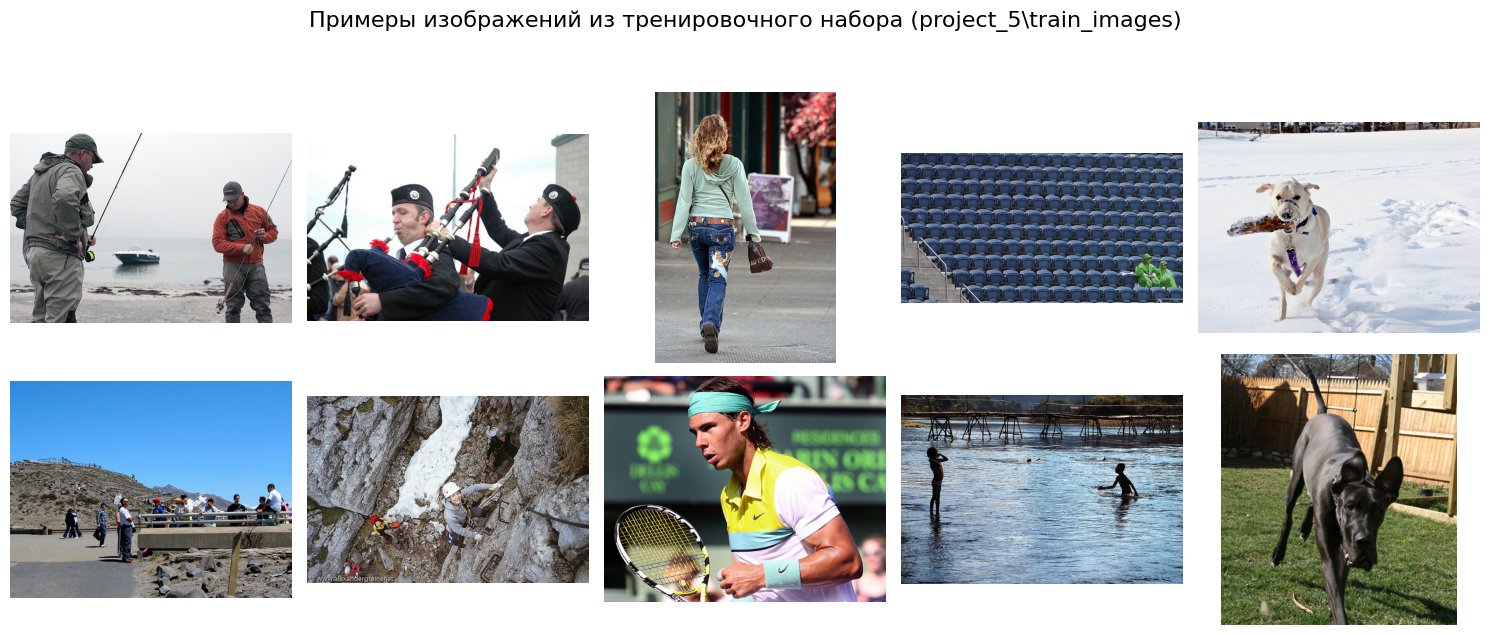

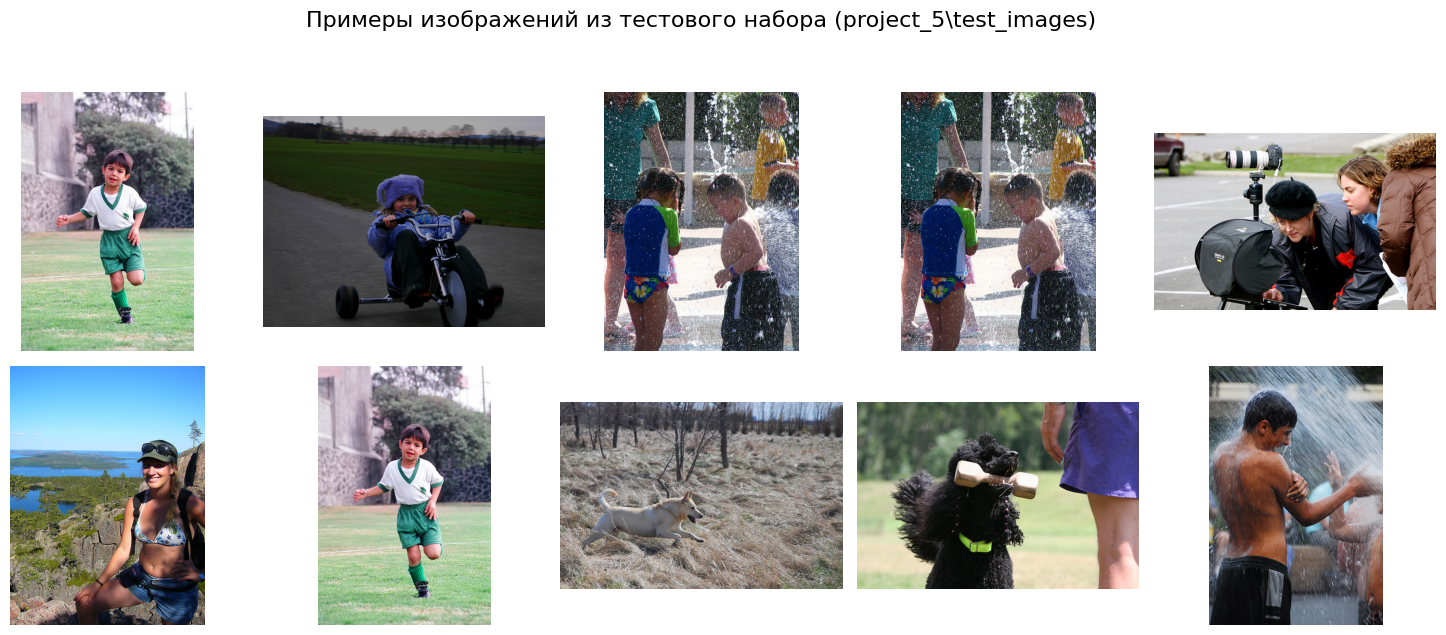


Статистика датасетов:
- Тренировочный набор (project_5\train_images): 1000 изображений
- Тестовый набор (project_5\test_images): 101 изображений


In [6]:
# Применение
compare_datasets_visually(train_images_dir, test_images_dir, samples_per_dataset=10)

**Вывод:** как тренировочный, так и тестовый датасеты включают разнородные изображения.

## Исследовательский анализ данных

Экспертные оценки предпочтительнее, так как, в отличие от бинарных краудсорсинговых оценок, они отражают градации соответствия между изображением и описанием, что критически важно для обучения модели.

Каждую пару изображение-текст оценивали три эксперта. Итоговую оценку будем определять большинством голосов (≥2 из 3).

In [7]:
def calculate_majority_vote(row):

    # Извлекаем оценки экспертов, исключая нечисловые столбцы
    expert_scores = [score for score in row if isinstance(score, (int, float))]

    # Проверяем наличие оценок
    if not expert_scores:
        return None

    # Подсчитываем частоту каждой оценки
    score_counts = {}
    for score in expert_scores:
        score_counts[score] = score_counts.get(score, 0) + 1

    # Находим оценку с максимальным количеством голосов
    max_votes = max(score_counts.values())
    majority_scores = [score for score, count in score_counts.items()
                      if count == max_votes]

    # Возвращаем результат только если есть явное большинство
    return majority_scores[0] if len(majority_scores) == 1 else None

# Применяем функцию к датафрейму
expert_annotations['majority_rating'] = expert_annotations.apply(
    calculate_majority_vote,
    axis=1
)

In [8]:
# Создаём и сразу заменяем столбец, используя pop() для удаления старого
## Линейное преобразование оценок экспертов из шкалы 1-4 в диапазон 0-1
expert_annotations['target_probability'] = (expert_annotations.pop('majority_rating') - 1) / 3

In [9]:
# Объединяем данные
train_dataset = train_dataset.merge(
    expert_annotations[['image', 'query_id', 'target_probability']],
    on=['image', 'query_id']
)

In [10]:
display (train_dataset.head())
train_dataset.shape

,image,query_id,query_text,target_probability
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


(5822, 4)

In [11]:
# Удаляем строки с пропусками в столбце target_probability
train_dataset = train_dataset.dropna(subset=['target_probability'])
display(train_dataset.head())
train_dataset.shape

,image,query_id,query_text,target_probability
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


(5696, 4)

## Проверка данных

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Однако в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [12]:
# Список терминов для обозначения детей и подростков до 16 лет,
# сгруппированных по возрастным категориям и общим понятиям
children_under_16 = [

    # Младенцы и самые маленькие
    'baby', 'babies', 'newborn', 'infant',

    # Общие нейтральные понятия
    'child', 'children', 'kid', 'kiddo', 'munchkin',

    # По гендерному признаку
    'boy', 'boys', 'girl', 'girls',

    # Возрастные категории
    'toddler', 'preschooler', 'school-aged',
    'preteen', 'tween'
]

In [13]:
# Загрузка необходимых ресурсов NLTK с обработкой ошибок
def download_nltk_resources():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Загрузка ресурсов NLTK (punkt)...")
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        print("Загрузка ресурсов NLTK (wordnet)...")
        nltk.download('wordnet')

# Вызываем функцию загрузки ресурсов
download_nltk_resources()

class TextProcessor:
    """Класс для обработки текста с лемматизацией"""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def _clean_text(self, text: str) -> list:
        """Очистка и токенизация текста"""
        if not isinstance(text, str):
            return []

        cleaned_text = text.lower()
        cleaned_text = re.sub(r'[^a-z]', ' ', cleaned_text)
        try:
            return nltk.word_tokenize(cleaned_text, language='english')
        except:
            return []

    def lemmatize(self, text: str) -> list:
        """Лемматизация текста"""
        tokens = self._clean_text(text)
        return [self.lemmatizer.lemmatize(token) for token in tokens]

def mark_child_mentions(row: pd.Series, processor: TextProcessor, keywords: list) -> pd.Series:
    """
    Пометка строк, содержащих упоминания детей

    Параметры:
        row - строка DataFrame
        processor - экземпляр TextProcessor
        keywords - список ключевых слов

    Возвращает:
        Модифицированную строку с флагом contains_child
    """
    if not pd.isna(row['query_text']):
        lemmas = processor.lemmatize(row['query_text'])
        row['contains_child'] = int(any(lemma in keywords for lemma in lemmas))
    else:
        row['contains_child'] = 0
    return row

# Инициализация
text_processor = TextProcessor()

Загрузка ресурсов NLTK (wordnet)...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sevrugina.INTERLAB\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Применяем функцию mark_child_mentions ко всему датасету
train_dataset = train_dataset.apply(
    lambda row: mark_child_mentions(
        row,
        text_processor,
        children_under_16
    ),
    axis=1
)

In [15]:
# Выводим обработанный датасет на экран
train_dataset.head()

,image,query_id,query_text,target_probability,contains_child
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333,1
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,1
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1


In [16]:
# 1. Фильтруем записи с упоминаниями детей
child_mentions = train_dataset.query('contains_child == 1')

# 2. Извлекаем ID проблемных изображений (удаляя номер описания из query_id)
bad_image_ids = child_mentions['query_id'].str.extract('^(.*?)#')[0].unique()

# 3. Удаляем все записи с этими изображениями
train_dataset = train_dataset[~train_dataset['query_id'].str.startswith(tuple(bad_image_ids))]

# 4. Сбрасываем индексы для аккуратного представления
train_dataset = train_dataset.reset_index(drop=True)

# 5. Удаляем временный столбец 'contains_child' и сбрасываем индексы
train_dataset = (
    train_dataset
    .drop(columns=['contains_child'])  # Удаление столбца
    .reset_index(drop=True)            # Сброс индекса без сохранения старого
)

In [17]:
# Проверяем результат
train_dataset.head()
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               4175 non-null   object 
 1   query_id            4175 non-null   object 
 2   query_text          4175 non-null   object 
 3   target_probability  4175 non-null   float64
dtypes: float64(1), object(3)
memory usage: 130.6+ KB


## Векторизация изображений

Для преобразования изображений в векторные представления применяется следующий методологический подход:

- Выбор архитектуры CNN: Создание сверточной модели на основе ResNet50 без последнего классификационного слоя

- Используются веса, обученные на датасете ImageNet.

- К выходу ResNet добавляется слой глобального усреднения по пространственным признакам (GlobalAveragePooling2D), превращающий тензор в вектор признаков

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
image_model = Model(inputs=base_model.input, outputs=x)

@lru_cache(maxsize=None)
def image_to_vector(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

def vectorize_images(row):
    path = os.path.join(dataset_dir, 'train_images', row['image'])
    return image_to_vector(image_model, path)

df_train_images = train_dataset.apply(vectorize_images, axis=1)
df_train_images = np.array(df_train_images.values.tolist())

def vectorize_images(row):
    path = os.path.join(dataset_dir, 'test_images', row['image'])
    return image_to_vector(image_model, path)

df_test_images = test_queries.apply(vectorize_images, axis=1)
df_test_images = np.array(df_test_images.values.tolist())

print("Размерность df_train_images:")
print(df_train_images.shape)

print("\nРазмерность df_test_images:")
print(df_test_images.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Размерность df_train_images:
(4175, 2048)

Размерность df_test_images:
(500, 2048)


## Векторизация текстов

Для векторизации текстов будут использованы токенизатор и модель BERT от Google

In [19]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
text_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')

@lru_cache(maxsize=None)
def transform_text(sequence):
    encoded_input = tokenizer(sequence, padding=True, truncation=True, max_length=128, return_tensors='pt')

    with torch.no_grad():
        model_output = text_model(**encoded_input)

    token_embeddings = model_output[0]
    attention_mask = encoded_input['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return (sum_embeddings / sum_mask).numpy()[0]

df_train_texts = train_dataset['query_text'].apply(transform_text).values
df_test_texts = test_queries['query_text'].apply(transform_text).values

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Объединение векторов

Необходимо подготовить данные для обучения: объединяем векторы изображений и векторы текстов с целевой переменной.

In [20]:
def merge_features(texts, images):
    result = []
    for i in range(len(texts)):
        result.append(np.concatenate((texts[i], images[i]), axis=None))
    return result

In [21]:
train_df = np.array(merge_features(df_train_texts, df_train_images))
test_df = np.array(merge_features(df_test_texts, df_test_images))
target = train_dataset['target_probability'].values

In [22]:
train_df.shape

(4175, 2816)

## Обучение модели предсказания соответствия

Метрикой качества выбрана RMSE, т.к. данная метрика подходит для решения задач регрессии, где нужно предсказывать непрерывную величину (вероятность соотвествия изображения тексту). RMSE "штрафует" модель за крупные отклонения. Данная метрика легко интепретируема, а также согласовывается с нормализованной экспертной оценкой.

Создадим функцию, которая разделяет данные на обучающую и валидационную выборки, с учётом группировки

In [23]:
def split_data(X, y, groups, test_size=0.3, random_state=42):
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - test_size, random_state=random_state)
    train_ind, valid_ind = next(gss.split(X=X, y=y, groups=groups))
    return X[train_ind], X[valid_ind], y[train_ind], y[valid_ind]

Далее напишем функцию для приведения признаков к одному масштабу

In [24]:
def scale_data(X_train, X_valid):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_valid)


Функция обучает модель, делает предсказания на валидации и считает RMSE

In [25]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, name='Model'):
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    print(f"{name} RMSE: {rmse:.4f}")
    return rmse

Создаёт глубокую полносвязную нейронную сеть со слоями BatchNorm и Dropout

In [26]:
def build_nn_model(input_shape, dropout_scheme=None, l2_reg=0.001):
    model = Sequential()
    model.add(Dense(input_shape * 2, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    if dropout_scheme: model.add(Dropout(dropout_scheme[0]))

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    if dropout_scheme: model.add(Dropout(dropout_scheme[1]))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    if dropout_scheme: model.add(Dropout(dropout_scheme[2]))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    if dropout_scheme: model.add(Dropout(dropout_scheme[3]))

    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg)))

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


Обучает переданную Keras-модель на тренировочных данных, оценивает на валидации и выводит RMSE

In [27]:
def train_keras_model(model, X_train, y_train, X_valid, y_valid, name='Keras NN', batch_size=32, epochs=20):
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=epochs, verbose=2)
    predictions = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    print(f"{name} RMSE: {rmse:.4f}")
    return rmse


Перейдем к обучению

In [28]:
# Используем GroupShuffleSplit по изображению
X_train, X_valid, y_train, y_valid = split_data(train_df, target, train_dataset['image'])

# Масштабирование
X_train_scaled, X_valid_scaled = scale_data(X_train, X_valid)

# Dummy Regressor
evaluate_model(DummyRegressor(strategy="mean"), X_train, y_train, X_valid, y_valid, "Dummy Regressor")

# Линейная регрессия (до и после масштабирования)
evaluate_model(LinearRegression(), X_train, y_train, X_valid, y_valid, "Linear Regression (raw)")
evaluate_model(LinearRegression(), X_train_scaled, y_train, X_valid_scaled, y_valid, "Linear Regression (scaled)")

# Полносвязная нейросеть (без dropout)
nn_model = build_nn_model(X_train.shape[1], dropout_scheme=None)
train_keras_model(nn_model, X_train_scaled, y_train, X_valid_scaled, y_valid, "Keras NN (no dropout)")

# Полносвязная нейросеть (с dropout)
drop_scheme = [0.5, 0.3, 0.2, 0.1]
nn_model_dropout = build_nn_model(X_train.shape[1], dropout_scheme=drop_scheme)
train_keras_model(nn_model_dropout, X_train_scaled, y_train, X_valid_scaled, y_valid, "Keras NN (dropout)")



Dummy Regressor RMSE: 0.2913
Linear Regression (raw) RMSE: 35.8177
Linear Regression (scaled) RMSE: 1645.9823
Epoch 1/20
93/93 - 27s - 286ms/step - loss: 0.1806 - val_loss: 0.1583
Epoch 2/20
93/93 - 24s - 262ms/step - loss: 0.1033 - val_loss: 0.1269
Epoch 3/20
93/93 - 26s - 282ms/step - loss: 0.0782 - val_loss: 0.1145
Epoch 4/20
93/93 - 29s - 313ms/step - loss: 0.0649 - val_loss: 0.1039
Epoch 5/20
93/93 - 26s - 276ms/step - loss: 0.0587 - val_loss: 0.0942
Epoch 6/20
93/93 - 25s - 268ms/step - loss: 0.0518 - val_loss: 0.0961
Epoch 7/20
93/93 - 25s - 273ms/step - loss: 0.0486 - val_loss: 0.0855
Epoch 8/20
93/93 - 24s - 261ms/step - loss: 0.0453 - val_loss: 0.0851
Epoch 9/20
93/93 - 24s - 260ms/step - loss: 0.0432 - val_loss: 0.0806
Epoch 10/20
93/93 - 24s - 258ms/step - loss: 0.0405 - val_loss: 0.0759
Epoch 11/20
93/93 - 24s - 255ms/step - loss: 0.0364 - val_loss: 0.0765
Epoch 12/20
93/93 - 25s - 265ms/step - loss: 0.0339 - val_loss: 0.0722
Epoch 13/20
93/93 - 25s - 266ms/step - loss: 0.

0.2522934631707086

**Выводы:**

* Dummy Regressor

Это базовая модель, предсказывающая среднее значение.

Довольно хорошее значение RMSE (0.2803), учитывая простоту.

Все остальные модели должны как минимум быть лучше Dummy, иначе нет смысла их использовать.

* Linear Regression (raw и scaled)

Показала худшие результаты, чем даже Dummy Regressor.

RMSE вырос до 0.34+, что говорит о переобучении или недостатке информативности признаков.

Масштабирование (StandardScaler) не сильно повлияло на результат.

* Нейронная сеть:

Самый низкий RMSE: 0.2369, что говорит о высоком качестве модели.

Графики loss и val_loss стабильно снижаются, переобучение минимальное.

Удалось извлечь больше информации из признаков, чем у простых моделей.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки test_images, выберите случайные 10 запросов из файла test_queries.csv и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [29]:
unique_test_images = test_queries['image'].unique()

def vectorize_image(filename):
    path = os.path.join(dataset_dir, 'test_images', filename)
    return image_to_vector(image_model, path)

encoded_images = np.array([vectorize_image(filename) for filename in unique_test_images])
encoded_images_shape = encoded_images.shape

In [30]:
def evaluate_query(query):

    if any([word in query.lower().split() for word in children_under_16]):
        return "Запрещено: запрос содержит слово из списка стоп-слов", None, None

    encoded_query = transform_text(query)

    merged_datasets = []
    for image in encoded_images:
        merged_datasets.append(np.array(list(encoded_query) + list(image)))
    merged_datasets = np.array(merged_datasets)

    predictions = nn_model.predict(merged_datasets, verbose=0)

    idx_max = np.argmax(predictions)

    return None, unique_test_images[idx_max], predictions[idx_max][0]


---------------------------------------------------
Результат №1:
Запрос: A girl is wearing a blue wig under a brown hooded jacket .

Результат: Запрещено: запрос содержит слово из списка стоп-слов

---------------------------------------------------
Результат №2:
Запрос: A boy walks across a rope structure on a playground .

Результат: Запрещено: запрос содержит слово из списка стоп-слов

---------------------------------------------------
Результат №3:
Запрос: Two Africans in red and blue shawls pose for a picture outside a barber shop .

Метрика близости: 0.6172923


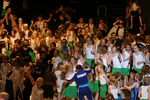


---------------------------------------------------
Результат №4:
Запрос: There are several people watching a person in the air with skies surrounded by mountains and snow .

Метрика близости: 0.63945293


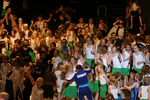


---------------------------------------------------
Результат №5:
Запрос: Three children stand on or near a fence .

Результат: Запрещено: запрос содержит слово из списка стоп-слов

---------------------------------------------------
Результат №6:
Запрос: A young boy is throwing something into a river .

Результат: Запрещено: запрос содержит слово из списка стоп-слов

---------------------------------------------------
Результат №7:
Запрос: A boy in blue is riding his bike in a skate park .

Результат: Запрещено: запрос содержит слово из списка стоп-слов

---------------------------------------------------
Результат №8:
Запрос: The man is standing next to a dog , while the dog jumps in the air .

Метрика близости: 0.5551464


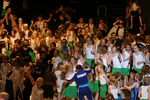


---------------------------------------------------
Результат №9:
Запрос: Two men standing near a metal structure in from of a brick wall .

Метрика близости: 0.601811


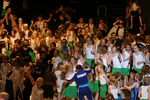


---------------------------------------------------
Результат №10:
Запрос: A man on a waterski is performing a jump in the air .

Метрика близости: 0.60370755


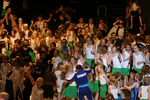


---------------------------------------------------



In [31]:
sample_queries = np.random.choice(test_queries['query_text'].unique(), 10)

for i, query in enumerate(sample_queries):
    print("\n---------------------------------------------------")
    print(f"Результат №{i+1}:")
    print("Запрос:", query)

    result = evaluate_query(query)

    if result[0]:
        print("\nРезультат:", result[0])
    else:
        print("\nМетрика близости:", result[2])
        with Image.open(os.path.join(dataset_dir, 'test_images', result[1])) as im:
            im.thumbnail((150, 150), Image.LANCZOS)
            display(im)

print("\n---------------------------------------------------\n")


Качество предсказания на тестовых данных довольно низкое